# Winning Attributes in the League of Legends Worlds 2024 Championship

Author: Matt Li

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. [Yes]

# Introduction
This is an analysis of the 2024 League of Legends World Championship, Riot's annual 5v5 multiplayer online battle arena event. Each player controls a unique character, called a champion, that fulfills a specific strategic role. Victory depends on gold accumulation (through farming, kills, and objectives), map control, and coordinated team play. Metrics like kills, gold share, vision, and early-game advantages often correlate with winrate—but as with any competitive setting, even strong predictors can fail in the face of unexpected comebacks or standout plays.

# Importing Libraries and Datasets
The main focus of analysis will be on the champions dataset with some interesting insight provided by the other 3 supporting datasets. The datasets are all some combination of a public dataset found on kaggle: ???

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from adjustText import adjust_text

champion = pd.read_csv("Champion.csv")
player = pd.read_csv("Player.csv")
team = pd.read_csv("Team.csv")
roles = pd.read_csv("Role.csv")

Champion.csv: Summarized stats for each champion-role combination across Worlds 2024 (e.g., kills, deaths, assists, CS, golds, winrate).

Player.csv: Per-game player stats across all roles.

Team.csv: Team-level stats for each game (e.g., total objectives, turrets destroyed, win/loss).

Role.csv: Match-level role assignments and opponents (used for lane matchup analysis).

In [6]:
print(champion.columns)

Index(['champion', 'role', 'kills', 'deaths', 'assists', 'cs', 'golds', 'dpm',
       'dmg%', 'kp%', 'gd@15', 'csd@15', 'xpd@15', 'vision_score',
       'total_objectives_stolen', 'turret_damage', 'cc_time', 'time_dead',
       'games_played', 'winrate'],
      dtype='object')


champion: name of the champion being analyzed.

role: in-game role the champion was played in (Top, Jungle, Mid, ADC, Support).

kills: number of enemy champions killed per game.

deaths: number of times the champion died per game.

assists: number of assists per game, contributing to team kills.

cs: Creep score — number of minions and monsters killed per game.

golds: Average gold earned per game.

dpm: Damage per minute — damage dealt to champions per minute.

dmg%: Percentage of the team’s total damage dealt contributed by this champion.

kp%: Kill participation — percentage of team kills the champion have assisted in (via kills or assists).

gd@15: Gold difference at 15 minutes, compared to the lane opponent.

csd@15: Creep score difference at 15 minutes, compared to the lane opponent.

xpd@15: Experience points difference at 15 minutes, compared to the lane opponent.

vision_score: Composite vision metric indicating wards placed, cleared, and map presence.

total_objectives_stolen: Number of major objectives (e.g., Dragon, Baron) stolen by the champion.

turret_damage: Total damage dealt to enemy structures. *This is debateably the one stat representing "true" progress towards winning the game as this is what is accumulated when you work towards destroying the enemy Nexus.

cc_time: Time (in seconds) spent applying crowd control effects to enemies.

time_dead: Total time (in seconds) the champion was dead during a game.

games_played: Number of games the champion was picked in during the tournament.

winrate: Percentage of games won when the champion was played.

In [8]:
print(player.columns)

Index(['player', 'role', 'kills', 'deaths', 'assists', 'cs', 'golds', 'dpm',
       'dmg%', 'kp%', 'gd@15', 'csd@15', 'xpd@15', 'vision_score',
       'objectives_stolen', 'turret_damage', 'cc_time', 'time_dead',
       'games_played', 'most_picked_champion'],
      dtype='object')


The player dataset consists of many of the same metrics as the champions dataset, but instead of the champion's average performance over the tournament, its the players. It adds on 'most_picked_champion' as a interesting metric to see for fans.

In [10]:
print(team.columns)

Index(['team', 'placement', 'avg_gd@15', 'avg_csd@15', 'avg_xpd@15',
       'avg_objectives', 'avg_vision_score'],
      dtype='object')


The teams dataset consists of each teams' average metrics across the 5 players in an effor to see if there is any correlation between early game leads to winrate of specific teams. 

# Analysis
This section explores patterns and relationships found through visualizations, relating them back to core mechanics and strategy in League of Legends (LoL). Each visualization was chosen to reflect a meaningful aspect of the game, such as gold economy, champion performance, and role-based contributions. Below, we walk through and interpret the key insights.

## Section 1: Early Advantages vs Tournament Placement
Within League, most champions are considered either front-loaded or back-loaded with power. Meaning they are regarded as strong in the early stages of the games or stronger as the game progresses. The general concensus is that if you win early, you should lose late, but player skill can cause a technically late-game character to gain a unusual lead in the early game or a mistake could cost a early-game character their entire momentum. The graph below is the correlation between early gold advanteage (which is often accompanied by cs and xp leads) and the team's overall placement in the tournament.

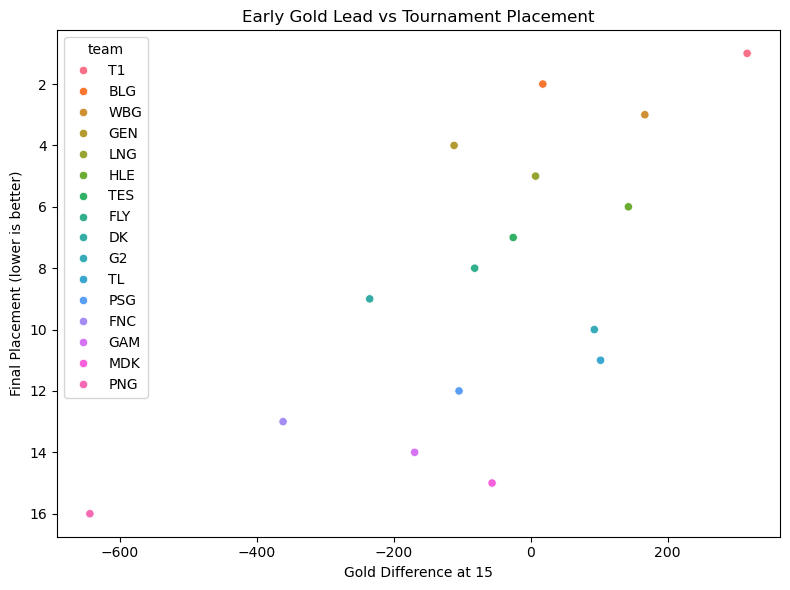

In [14]:
# Plotting
plt.figure(figsize=(8,6))
sns.scatterplot(data=team, x="avg_gd@15", y="placement", hue="team")
plt.title("Early Gold Lead vs Tournament Placement")
plt.xlabel("Gold Difference at 15")
plt.ylabel("Final Placement (lower is better)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This graph shows a faint positive correlation which highlights the relationship between early-game gold advantage and final tournament placement. The faint trend suggests that teams with stronger early-game economic control tend to place higher, however, the spread also reveals that early gold leads are not the sole determinant of success — some teams with modest or even negative gold differences still managed strong finishes.

## Section 2: Different Standardized Stats by Roles
Since the 5 roles all exhibit difference roles, it could be very interesting to see which roles excel particularly at which metrics. 6 stats thought to represent each role the most were chosen, standardized, and displayed below to allow for easy comparison.

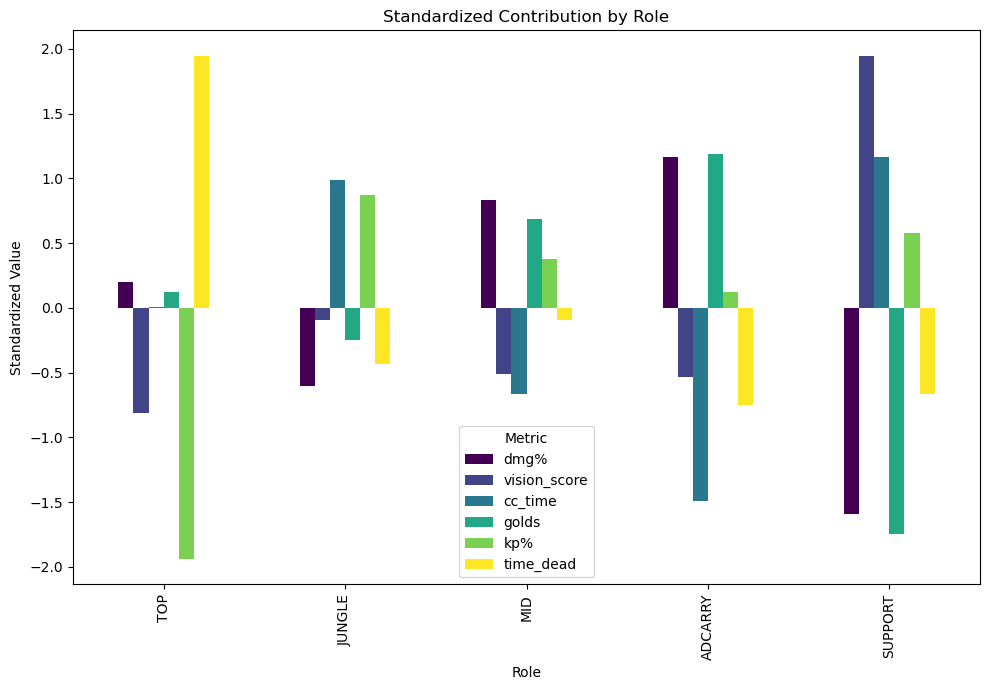

In [17]:
# Select and standardize key metrics from role stats
role_stats = roles.set_index("role")[["dmg%", "vision_score", "cc_time", "golds", "kp%", "time_dead"]]
role_stats_scaled = pd.DataFrame(StandardScaler().fit_transform(role_stats),
                                 columns=role_stats.columns,
                                 index=role_stats.index)

# Plot stacked contribution
role_stats_scaled.plot(kind="bar", figsize=(10, 7), colormap="viridis")
plt.title("Standardized Contribution by Role")
plt.ylabel("Standardized Value")
plt.xlabel("Role")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


Here, standardized metrics across roles help us see which positions are statistically dominant in various areas (e.g., vision, gold, kill share). This allows us to compare roles on equal footing. There exist many clear outliers, such as Top's low kp while high time spent dead, Jungle's low contribution to overall damage, but above average CC and vision score, Mid's overall average for all 6 metrics, ADC's clear advantage in damage and lack of CC, and finally Support's part in providing CC and vision.

The graph clearly shows the intentional strength and weaknesses given to each role, most clearly, the trade off of damage for other forms of utility, most often cc. It is also clear that the 2 roles that roams the map the most, Jungle and Support, contributes most the team's vision.

## Section 3: Correlation Between Gold Gained vs Winrate?
When a game is being broadcasted, often the metric for determining a live game's result is the gold advantage one team has over another. The dataset failed to contain a column of gold difference at the end of a game, but by standardizing the gold gained column, it can mimic the result as the more gold a champion gains, their winrate will increase, though the increase is not uniform across all champions.

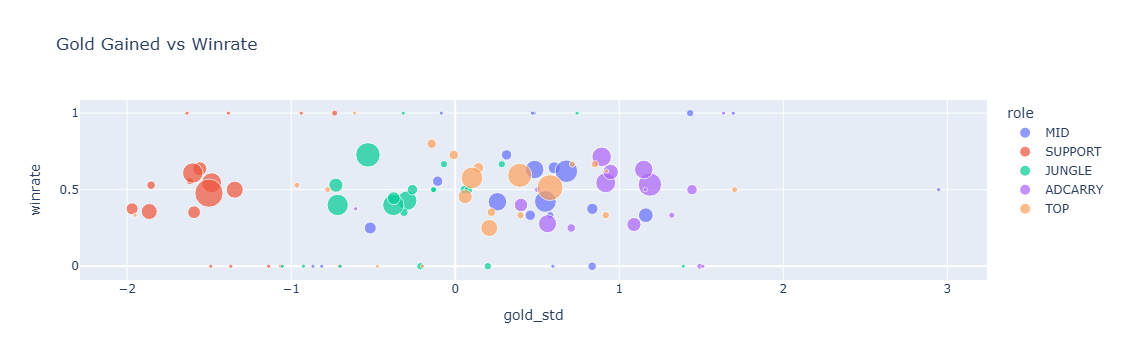

In [20]:
# Standardizing gold gained
champion['gold_std'] = StandardScaler().fit_transform(champion[['golds']])

# Plotting
fig = px.scatter(
    champion,
    x="gold_std", 
    y="winrate",
    size="games_played",
    color="role",
    hover_name="champion",
    title="Gold Gained vs Winrate"
)
fig.show()

The size represents the amount a specific champion was played, clearly as a champion is played more and more, their winrate converges towards a 50% winrate with variation on either side. This is most likely due to some champions being a popular "counter-pick" meaning that they are picked to counter a specific opposing team composition or specific enemy champion, skewing the counter's winrate higher and the countered winrate lower.

## Section 4: PCA + K Means Clustering
There exist 5 roles in league, Top, Jungle, Mid, ADC, Support, each of which has a particular niche, though some cover a wider varity than others. The more defined of which are Top, ADC, and Support. Top often consists of more bulkier champions capable of soaking up and dishing out a considerable amount of damage. ADC is the main back-bone of a team's damage output, but often left intentionally fragile and in need of protection from teammates. Supports are full of utility, either in the form of being a damage sponge or providing buffs and shields. Mid and Jungle both have the most options to their playstyle, either as assassins, mages, tanks, or utility, the list truly goes on. This should in theory effect the clustering of roles, but as discussed, there are some significant overlap in some role's niches in game, so some misclassification/clustering should be expected.

PCA was chosen to condense the many columnes of the champions column to see if there are any distinct attributes that could help clustering. PCA reduces dimensionality by projecting data onto the directions of greatest variance, allowing us to visualize the main statistical patterns across champions in just two components. The clustering will rely on K Means, but since KMeans relies on distance metrics, clusters may not reflect discrete role categories—especially when roles overlap statistically (e.g., tanky supports vs tanky tops).

C:\Users\mingy\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\Users\mingy\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\mingy\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mingy\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\mingy\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable

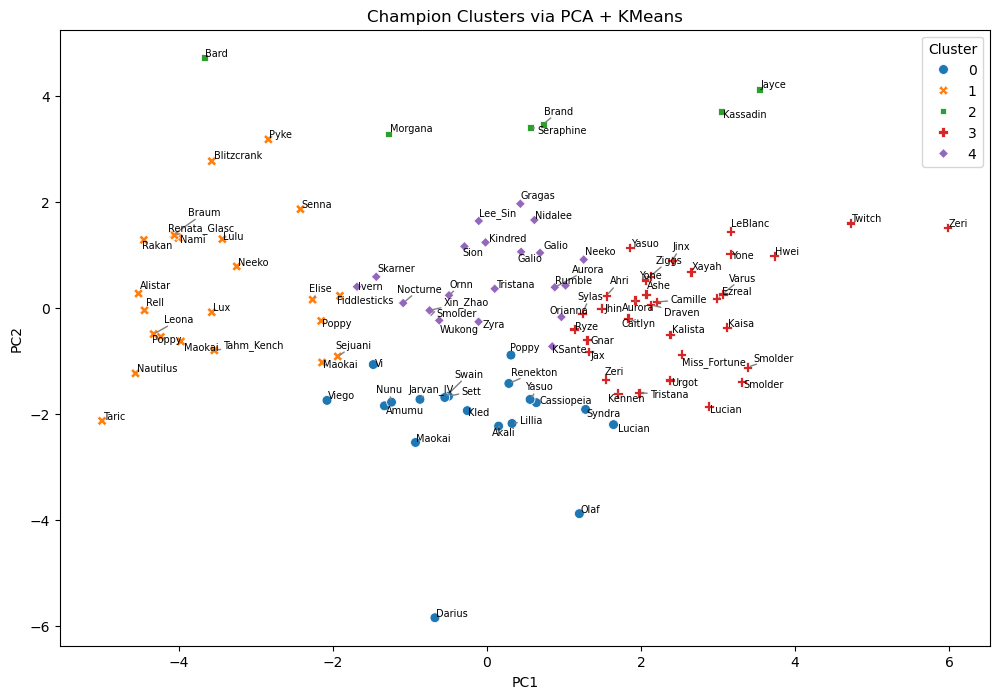

In [23]:
# Identifying features
champion_features = champion.select_dtypes(include='number').drop(columns=["games_played"])
scaled = StandardScaler().fit_transform(champion_features)

# PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=1)
labels = kmeans.fit_predict(reduced)

# Plot
champion_plot_df = pd.DataFrame(reduced, columns=["PC1", "PC2"])
champion_plot_df["Cluster"] = labels
champion_plot_df["Champion"] = champion["champion"]

plt.figure(figsize=(12,8))
sns.scatterplot(data=champion_plot_df, x="PC1", y="PC2", hue="Cluster", style="Cluster", palette="tab10", s=50)
texts = []
for i in range(len(champion_plot_df)):
    texts.append(plt.text(champion_plot_df.PC1[i], champion_plot_df.PC2[i], champion_plot_df.Champion[i], fontsize=7))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=1))
plt.title("Champion Clusters via PCA + KMeans")
plt.show()


This PCA and K Means projection reveals the compressed, 2D structure of champion statistics using the many variables within the champions dataset then clustering them using each nodes commonalities. There seems to be distinct clusters, but looking closely at the actual champions there seems to be a lot of unexpected overlap. Starting from the left, the orange x's consists of almost entirely of supports with the exception of Elise and Poppy being classified as Support and it missing Senna and Morgana. The green squares is a mixed bunch of majority Junglers, with a few tops and mids mixed within. The blue circles is a solid mix of Top, Jungle, and Mid. The red +'s are mostly Mids and ADCs witha few Top laners. Lastly the purple has only a few champions from Mid or ADC.

Looking at the general pattern, the orange is probably champions that deal little damage, but has high cc time and vision score. Green is champions with mostly high kp. Green is consisted of high dmg, cc time, and maybe time spent dead. Red is champions who accumulate high damage, cs, and kills with little cc and time spent dead. Purple appears to be a more extreme version of red, with many "hyper-carries" in that cluster.

## Section 5: Classification of Player's Roles by Corresponding Stats
Instead of classifying a champion's role, let's try to predict a player's role by their average stats. Random forest might have better here since it fits a number of decision tree regressors on a number of samples that are averaged in order to improve the accuracy in predictions. Random Forests reduce variance by averaging over many decision trees, which helps prevent overfitting. However, since each tree still fits training data closely, there is a bias-variance tradeoff where some fine-tuning could further improve generalization. To reduce the possibility of overfitting,  a stratified 5-Fold cross-validation was used, which helps better evaluate model generalization across the full dataset while preserving class balance across folds.

In [26]:
# Encode roles
le = LabelEncoder()
y = le.fit_transform(player["role"])
X = player.drop(columns=["player", "role", "most_picked_champion"])

# Initialize model
model = RandomForestClassifier(n_estimators=100, random_state=3)

# Use Stratified K-Fold to preserve role distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# Cross-validation accuracy
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
print(f"Cross-validated Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

Cross-validated Accuracy Scores: [0.82352941 0.75       0.8125     0.875      0.9375    ]
Mean Accuracy: 0.8397 (+/- 0.0630)


As shown in the matrix above, the Random Forest is able to correctly predict the role of any player with around 84% accuracy. Clearly, though there exists many champions that could be played in a certain role, there exists some continuity throughout the games. This could either be due to teams' meta reads, or what they decide is strong, therefore they might play similar champions in certain roles or some other causes. Regardless, this speaks volumes to how a role affects a player's playstyle and niche in the game and the metrics that result from the playstyle.

## Section 5.1: Feature Selection for Role Prediction
As an extension to the previous analysis, I was curious to see which attributes the algorithm decided to rely on the most to determine the roles.

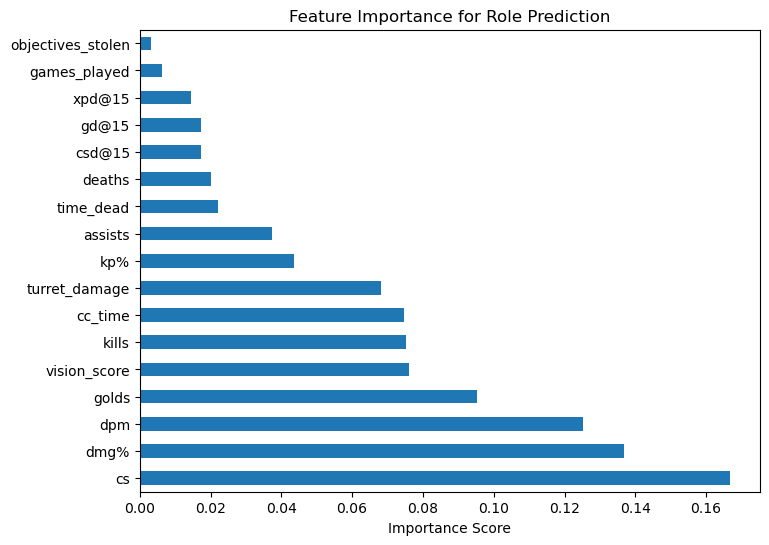

In [29]:
# Fit the model for importance analysis
model.fit(X, y)

# Calculate feature importance and PLot
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind="barh", figsize=(8,6), title="Feature Importance for Role Prediction")
plt.xlabel("Importance Score")
plt.show()

Clear winners are vision score, dpm, dmg%, and cs. I'm personally very suprised dpm and dmg% have such a discrepency of importance, since they rperesent a similar stat to me and I intuitively think there should be some heavy correlation between the two, but then again maybe a difference of 6% isn't as much as I think considering half of the metrics are below 6% importance. Vision score definitely was no suprise as seen from section 2, support and jungle takes up the responsibility of providing them for a team. 

# Final Takeaways

- Statistical role prediction is feasible with high accuracy using models like Random Forest, highlighting consistent gameplay patterns across positions.
- Clustering via PCA and KMeans reveals meaningful, though imperfect, grouping based on champion playstyles—particularly clear for Support and carries.
- Metrics like vision score, damage share, and CS are among the most influential in determining both role identity and early leads increases winrate potential with varying success.


## References
initial dataset - https://www.kaggle.com/datasets/smvjkk/league-of-legends-worlds-mainevent-2024-stats  
inspiration for the project - https://www.kaggle.com/code/fortyeth/analyzing-win-attributes-in-league-of-legends